In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, GridSearchCV
from xgboost.sklearn import XGBClassifier 
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

In [15]:
cut='Resolved_SR' # Boosted_SR or Resolved_SR
year='2017_v7'       #version of the samples, must correspond to the name of the folder in base_dir

base_dir='D:\\Travail\\ZV_analysis\samples\ZV_'
fig_dir='D:\\Travail\\ZV_analysis\\BDT\\'+year+'\\'+cut+'\\figs'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

samples_dir=base_dir+year+"\\"+cut+'\samples\\v1'

variables_list=['pt1', 'pt2', 'eta1', #ist of variables present in the files for later use
       'eta2', 'mll', 'nFatJet',
       'FatJet_pt', 'FatJeteta',
       'FatJet_softdropmass', 'FatJet_tau21',
       'Zlep_1', 'Zlep_2', 'category',
       'vbs_jet_pt1', 'vbs_jet_pt2',
       'vbs_jet_eta1', 'vbs_jet_eta2',
       'V_jet_pt1', 'V_jet_pt2',
       'V_jet_eta1', 'V_jet_eta2',
       'mjj_max', 'detajj_mjjmax',
       'V_jet_mass', 'weight_']

In [16]:
def normalize(data):
    #to balance the sample: SoW for signal = SoW bkg
    data['w']=0
    N_sig=len(data[data['signal']==1])
    SoW_sig=sum(data['weight_'][data['signal']==1])
    SoW_bkg=sum(data['weight_'][data['signal']==0])
    coef_sig=N_sig/SoW_sig
    coef_bkg=N_sig/SoW_bkg
    data['w'][data['signal']==0]=coef_bkg
    data['w'][data['signal']==1]=coef_sig
    data['w']=data['w']*data['weight_']

def groupplot_var(var,xmin=0, xmax=1000,nbins=50, weight='std'):
    #plot hist for every variables for signal vs DY vs top vs others
    plt.figure(figsize=(8,5))
    groups=['DY','top','other','signal']
    color=['green', 'orange','blue','red']
    bins=np.linspace(xmin, xmax,nbins)
    for j,group in enumerate(groups):
        if weight=='std':
            w=df['weight_'][df['group']==group]
        else:
            w=weight
        plt.hist(df[var][df['group']==group],bins=bins,histtype='step',color=color[j],label=group, density=True, weights=w);
    plt.xlabel(var,fontsize=12);
    plt.ylabel('Events',fontsize=12);
    plt.legend(frameon=True);
    plt.savefig(fig_dir+'/{}.png'.format(var))

def AUC(label, pred):
    #build AUC and ROC
    plt.figure(figsize=(5,5))
    fpr, tpr, threshold = metrics.roc_curve(label,pred, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    print ("AUC Score (Test): {:4%}".format(roc_auc))
    plt.plot(tpr,(1-fpr), label =' AUC = %0.4f' %(roc_auc))
    #plt.ylim(0.6,1.05)
    plt.xlabel('Signal efficiency')
    plt.ylabel('Background reduction')
    plt.title('BDT ROC curve')
    plt.grid()
    plt.legend()
    plt.savefig(fig_dir+'/Roc.png')
    


In [17]:
files=os.listdir(samples_dir)
samples_name=[file[:-10] for file in files]

samples_group=[]
#group samples by 'class'
for sample in samples_name:
    if 'DY' in sample: samples_group.append('DY')
    elif 'top' in sample: samples_group.append('top')
    elif 'VBS_ZV' in sample: samples_group.append('signal')
    else : samples_group.append('other')
    
samples_df=[]

df=pd.DataFrame()

# preparing the samples for later
for i,name in enumerate(files):
    samples_df.append(pd.read_pickle(samples_dir+'\\'+files[i]))
    samples_df[i]['sample']= samples_name[i]
    samples_df[i]['group']=samples_group[i]
    df=df.append(samples_df[i], sort=False)
df['signal']=df['group']=='signal'
df.replace(np.inf, -999,inplace=True)
df.replace(-np.inf, -999, inplace=True)
#df.to_pickle(base_dir+year+'//'+cut+'.pkl')
#save full dataframe to pkl in base_dir

In [ ]:
#plot variables

var=[cut+'_'+i for i in variables_list]

xlims=[(0,600),(0,250),(-5,5),(-5,5),(0,150),(0,10),(0,900),(-5,5),(0,250), # adjust plots limits
       (0,1),(-1.5,1.5),(-1.5,1.5),(-1,1),(0,200),(0,200),(-5,5),(-5,5),
       (0,200),(0,100),(-5,5),(-5,5),(0,3000),(0,10),(0,300),(0,0.01)]

for i,var in enumerate(var):
    if 'weight' in var:
        var='weight_'
        groupplot_var(var,xmin=xlims[i][0],xmax=xlims[i][1],weight=None)
    else :
        groupplot_var(var,xmin=xlims[i][0],xmax=xlims[i][1])

In [ ]:
# scatter plot pt vs eta

groups=['DY','top','other','signal']
#groups=['DY']
color=['green', 'orange','blue','red']
plt.figure(figsize=(15,10))
if cut=='Boosted_SR':
    jetcats=['vbs_jet', 'FatJet']
if cut=='Resolved_SR':
    jetcats=['vbs_jet', 'V_jet']

for jetcat in jetcats:
    for jet in [1,2]:
        plt.figure(figsize=(15,10))
        for j,group in enumerate(groups):
            if jetcat != 'FatJet':
                x=cut+'_'+jetcat+'_pt'+str(jet)
                y=cut+'_'+jetcat+'_eta'+str(jet)
                title=year+cut+'_'+jetcat+str(jet)
            else: 
                x=cut+'_'+jetcat+'_pt'
                y=cut+'_'+jetcat+'eta'
                title=year+cut+'_'+jetcat
            plt.scatter(df[x][df['group']==group],df[y][df['group']==group],color=color[j],label=group, s=1);
            plt.xlabel('pt',fontsize=12);
            plt.ylabel('eta',fontsize=12);
            plt.title(title)
            if cut=='Resolved_SR':
                plt.xlim(0,600)
            if cut=='Boosted_SR':
                plt.xlim(0,2200)
            plt.legend(frameon=True);
            plt.savefig(fig_dir+'/{}.png'.format(title))


In [18]:
#data preparation for BDT
features_Resolved=['pt1', 'pt2', 'eta1',
       'eta2', 'mll',
       'Zlep_1', 'Zlep_2', 
       'vbs_jet_pt1', 'vbs_jet_pt2',
       'vbs_jet_eta1', 'vbs_jet_eta2',
       'V_jet_pt1', 'V_jet_pt2',
       'V_jet_eta1', 'V_jet_eta2',
       'mjj_max', 'detajj_mjjmax',
       'V_jet_mass']
features_Boosted=['pt1', 'pt2', 'eta1',
       'eta2', 'mll',
       'FatJet_pt', 'FatJeteta',
       'Zlep_1', 'Zlep_2', 
       'vbs_jet_pt1', 'vbs_jet_pt2',
       'vbs_jet_eta1', 'vbs_jet_eta2',
       'mjj_max', 'detajj_mjjmax']
#removed 'V_jet_mass' FatJet_tau21'


if cut == 'Resolved_SR':
    features=['Resolved_SR_'+i for i in features_Resolved]
elif cut == 'Boosted_SR':
    features=['Boosted_SR_'+i for i in features_Boosted]
    
    
    
x=df[features]
# Normalize features to optimize performance (min max scaler)
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(x)
y=df[['signal','sample','group','weight_']]
y['signal']=y['signal'].astype('int32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
train = xgb.DMatrix(data=X_train,label=y_train['signal'], feature_names=features)
test = xgb.DMatrix(data=X_test,label=y_test['signal'],feature_names=features)


#create sample wo tops for tests
X_top=X[df['sample']!='top']
y_top=df[['signal','sample','group','weight_']][df['sample']!='top']
y_top['signal']=y_top['signal'].astype('int32')
X_top_train, X_top_test, y_top_train, y_top_test = train_test_split(X_top, y_top, test_size=0.2, random_state=42, shuffle=True)


#cut above jet_pt 50 for tests
if cut=='Boosted_SR':
    cond=(df['Boosted_SR_vbs_jet_pt1']>50.)& (df['Boosted_SR_vbs_jet_pt2']>50.)
else:
    cond= (df['Resolved_SR_vbs_jet_pt1']>50.) & (df['Resolved_SR_vbs_jet_pt2']>50.)& (df['Resolved_SR_V_jet_pt1']>50.)& (df['Resolved_SR_V_jet_pt2']>50.)


X_50pt=X[cond]
y_50pt=y[cond]
X_50pt_train, X_50pt_test, y_50pt_train, y_50pt_test = train_test_split(X_50pt, y_50pt, test_size=0.2, random_state=42, shuffle=True)
    
#rebalance samples    
    
normalize(y_train)
train_weighted = xgb.DMatrix(data=X_train,label=y_train['signal'], feature_names=features, weight=y_train['w'])


normalize(y_test)
test_weighted = xgb.DMatrix(data=X_test,label=y_test['signal'], feature_names=features, weight=y_test['w'])

normalize(y_top_train)
train_top_weighted = xgb.DMatrix(data=X_top_train,label=y_top_train['signal'], feature_names=features, weight=y_top_train['w'])

normalize(y_50pt_train)
train_50pt_weighted =xgb.DMatrix(data=X_50pt_train,label=y_50pt_train['signal'], feature_names=features, weight=y_50pt_train['w'])

normalize(y_50pt_test)
test_50pt_weighted =xgb.DMatrix(data=X_50pt_test,label=y_50pt_test['signal'], feature_names=features, weight=y_50pt_test['w'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pa

# BDT training

[0]	train-error:0.25482	train-logloss:0.67755	train-auc:0.82421	test-error:0.25668	test-logloss:0.67769	test-auc:0.82268
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 5 rounds.
[10]	train-error:0.22251	train-logloss:0.58110	train-auc:0.85761	test-error:0.22968	test-logloss:0.58351	test-auc:0.85214
[20]	train-error:0.21776	train-logloss:0.52777	train-auc:0.86375	test-error:0.22316	test-logloss:0.53199	test-auc:0.85781
[30]	train-error:0.21409	train-logloss:0.49722	train-auc:0.86733	test-error:0.22312	test-logloss:0.50375	test-auc:0.85965
[40]	train-error:0.21221	train-logloss:0.47713	train-auc:0.87007	test-error:0.21992	test-logloss:0.48578	test-auc:0.86119
[50]	train-error:0.20997	train-logloss:0.46434	train-auc:0.87243	test-error:0.21914	test-logloss:0.47515	test-auc:0.86247
[60]	train-error:0.20787	train-logloss:0.45540	train-auc:0.87511	test-error:0.21855	test-logloss:0.46871	test-auc:0.86358
[70]	tr

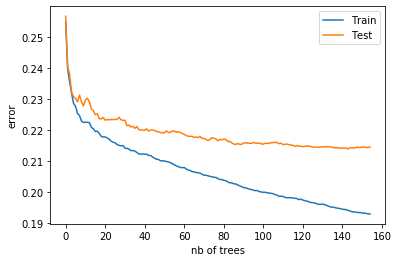

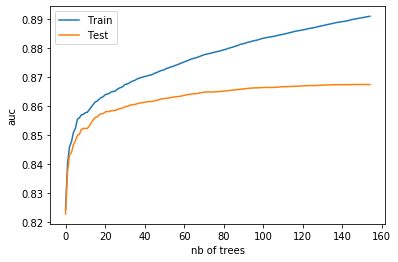

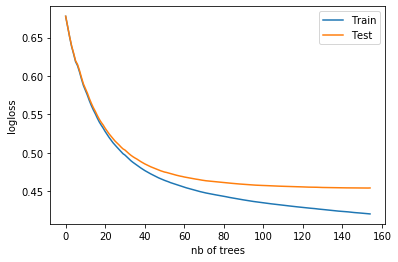

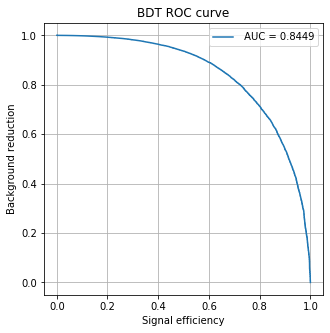

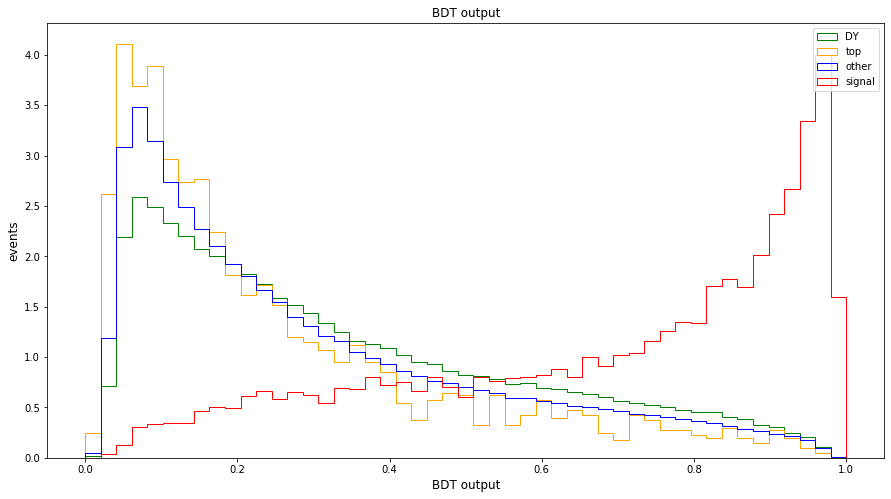

In [19]:
%%time
#data = train_weighted
data=train_weighted
test=test_weighted
labels=y_test


def learning_rate_decay(boosting_round, num_boost_round):
    #decay if we want to use
    learning_rate_start = 0.3
    learning_rate_min = 0.01
    lr_decay = 0.999
    lr = learning_rate_start * np.power(lr_decay, boosting_round)
    return max(learning_rate_min, lr)    
    
    
param = {}

#param['min_child_weight']=sum(y_train['w'])/len(y_train)          #min child weight= average weigth
param['min_child_weight']=sum(y_train['w'])/len(y_train)
#Resolved: best params = 0.05 6
#boosted 0.05 6
# Booster parameters
param['nthread']          = 12  # limit number of threads
param['eta']              = 0.05 # learning rate
param['max_depth']        = 6  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'auc')]

num_trees = 800 # number of trees to make

watchlist= [(data,'train'), (test,'test')]
progress={}
booster = xgb.train(param,data,num_boost_round=num_trees, evals=watchlist, evals_result=progress, verbose_eval=10, early_stopping_rounds=5)
print('training done')
predictions_BDT=booster.predict(test)
pred_proba=booster.predict(test)
predictions=[round(value) for value in predictions_BDT]
accuracy = accuracy_score(labels['signal'], predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


#plot metrics on train and test samples
results = progress
metric='error'
epochs = len(results['train'][metric])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['train'][metric], label='Train')
ax.plot(x_axis, results['test'][metric], label='Test')
ax.legend()
plt.ylabel(metric)
plt.xlabel('nb of trees')
plt.draw()
plt.savefig(fig_dir+'/{}.png'.format('error'))


metric='auc'
epochs = len(results['train'][metric])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['train'][metric], label='Train')
ax.plot(x_axis, results['test'][metric], label='Test')
ax.legend()
plt.ylabel(metric)
plt.xlabel('nb of trees')
plt.draw()
plt.savefig(fig_dir+'/{}.png'.format('auc'))


metric='logloss'
epochs = len(results['train'][metric])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['train'][metric], label='Train')
ax.plot(x_axis, results['test'][metric], label='Test')
ax.legend()
plt.ylabel(metric)
plt.xlabel('nb of trees')
plt.draw()
plt.savefig(fig_dir+'/{}.png'.format('logloss'))

#plot AUC
AUC(y_test['signal'], pred_proba)

import numpy as np
#plot BDT ouput by sample
plt.figure(figsize=(15,8))
groups=['DY','top','other','signal']
color=['green', 'orange','blue','red']
x=[]
for i,group in enumerate(groups):    
    plt.hist(predictions_BDT[y_test['group']==group],bins=np.linspace(0,1,50), label=group, density=True, histtype='step', color=color[i])
plt.xlabel('BDT output',fontsize=12)
plt.ylabel('events',fontsize=12)
plt.title('BDT output')
plt.legend()
plt.savefig(fig_dir+'/BDT_output.png')

In [20]:
#Save model

booster.save_model('D:\\Travail\\ZV_analysis\\BDT\\{}_{}.model'.format(year,cut))

AUC Score (Test): 84.491195%


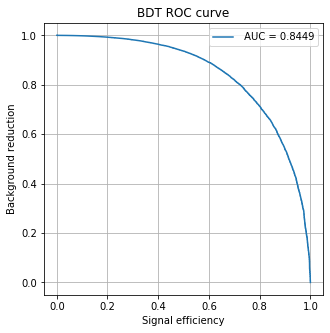

In [21]:
#load model
bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model('D:\\Travail\\ZV_analysis\\BDT\\{}_{}.model'.format(year,cut))
pred=bst.predict(test_weighted)

AUC(y_test['signal'],pred)

## Variant of the training with option to test on different sample

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


AUC Score (Test): 70.535724%


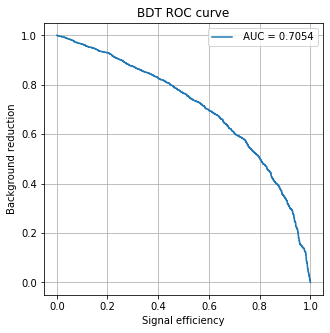

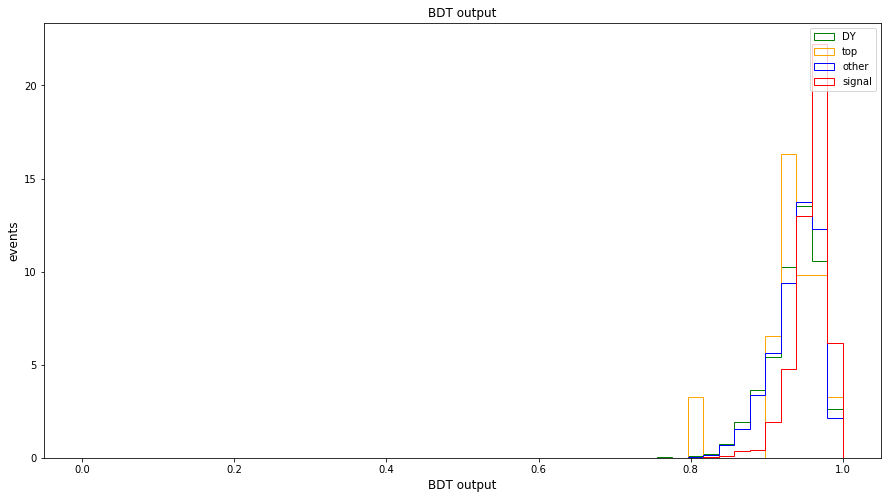

In [57]:
#test model on 2017 data
#cut='Boosted_SR' # Boosted_SR or Resolved_SR
year='2017_v7'
training='2018'
base_dir='D:\\Travail\\ZV_analysis\samples\ZV_'
cut_50pt=True
if cut_50pt==True:
    fig_dir='D:\\Travail\\ZV_analysis\\BDT\\'+year+'\\'+cut+'_50pt\\figs'
else: 
    fig_dir='D:\\Travail\\ZV_analysis\\BDT\\'+year+'\\'+cut+'\\figs'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

samples_dir=base_dir+year+"\\"+cut+'\samples\\v1'


files=os.listdir(samples_dir)
samples_name=[file[:-10] for file in files]

samples_group=[]
for sample in samples_name:
    if 'DY' in sample: samples_group.append('DY')
    elif 'top' in sample: samples_group.append('top')
    elif 'VBS_ZV' in sample: samples_group.append('signal')
    else : samples_group.append('other')
    
samples_df=[]

df=pd.DataFrame()
for i,name in enumerate(files):
    samples_df.append(pd.read_pickle(samples_dir+'\\'+files[i]))
    samples_df[i]['sample']= samples_name[i]
    samples_df[i]['group']=samples_group[i]
    df=df.append(samples_df[i], sort=False)
df['signal']=df['group']=='signal'
df.replace(np.inf, -999,inplace=True)
df.replace(-np.inf, -999, inplace=True)

if cut == 'Resolved_SR':
    features=['Resolved_SR_'+i for i in features_Resolved]
elif cut == 'Boosted_SR':
    features=['Boosted_SR_'+i for i in features_Boosted]
    
    
    
x=df[features]
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(x)
y=df[['signal','sample','group','weight_']]
y['signal']=y['signal'].astype('int32')

#renormalize samples
if cut_50pt==True:
#cut above jet_pt 50
    if cut=='Boosted_SR':
        cond=(df['Boosted_SR_vbs_jet_pt1']>50.)& (df['Boosted_SR_vbs_jet_pt2']>50.)
    else:
        cond= (df['Resolved_SR_vbs_jet_pt1']>50.) & (df['Resolved_SR_vbs_jet_pt2']>50.)& (df['Resolved_SR_V_jet_pt1']>50.)& (df['Resolved_SR_V_jet_pt2']>50.)
    #renormalize samples

    X=X[cond]
    y=y[cond]

normalize(y)
sample_2017_weighted = xgb.DMatrix(data=X,label=y['signal'], feature_names=features,weight=y['w'])

bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model('D:\\Travail\\ZV_analysis\\BDT\\{}_{}.model'.format(training,cut))
predictions_2017=bst.predict(sample_2017_weighted)
AUC(y['signal'], predictions_2017)


#plot BDT ouput by sample
plt.figure(figsize=(15,8))
groups=['DY','top','other','signal']
color=['green', 'orange','blue','red']
x=[]
for i,group in enumerate(groups):    
    plt.hist(predictions_2017[y['group']==group],bins=np.linspace(0,1,50), label=group, density=True, histtype='step', color=color[i])
plt.xlabel('BDT output',fontsize=12)
plt.ylabel('events',fontsize=12)
plt.title('BDT output')
plt.legend()
plt.savefig(fig_dir+'/BDT_output.png')

# Grid search to optimize lr and tree depth

In [13]:
%%time
#grid search

def learning_rate_decay(boosting_round, num_boost_round):
    learning_rate_start = 0.3
    learning_rate_min = 0.01
    lr_decay = 0.999
    lr = learning_rate_start * np.power(lr_decay, boosting_round)
    return max(learning_rate_min, lr)

data=train_weighted
param_init = {}
param_init['min_child_weight']=sum(y_train['w'])/len(y_train)          #min child weight= average weigth
# Booster parameters
param_init['nthread']          = 12  # limit number of threads
param_init['subsample']        = 0.8 # fraction of events to train tree on
param_init['colsample_bytree'] = 0.8 # fraction of features to train tree on

# Learning task parameters
param_init['objective']   = 'binary:logistic' # objective function
param_init['eval_metric'] = 'auc'           # evaluation metric for cross validation
#param_init = list(param_init.items()) + [('eval_metric', 'error')] + [('eval_metric', 'auc')]

num_trees = 800 # number of trees to make
watchlist= [(data,'train'), (test_weighted,'test')]
progress={}


### grid search over lr and mac depth
lr_grid=[0.01,0.05,0.1,0.2,0.3]
depth_grid=[4,5,6,10]
best_params={'lr': 0, 'depth':0, 'auc':0}
max_auc=0
result={}
n_iter=0

print('performing grid search over {} iterations'.format(len(lr_grid)*len(depth_grid)))
for i in lr_grid:
    for j in depth_grid:
        param=param_init
        n_iter +=1
        print('iteration {} : training with lr:{}, depth:{}'.format(n_iter,i,j))
        param['eta']              = i # learning rate
        param['max_depth'] =j
        booster = xgb.train(param,data,num_boost_round=num_trees, evals=watchlist, evals_result=progress, 
                            early_stopping_rounds=5, verbose_eval=100)
        preds=booster.predict(test_weighted)
        fpr, tpr, threshold = metrics.roc_curve(y_test['signal'], preds, pos_label=1)
        auc = metrics.auc(fpr, tpr)
        result[n_iter]={'lr': i, 'depth':j, 'auc':auc}
        print('auc:{}'.format(auc))
        if auc >= max_auc:
            max_auc=auc
            best_params['lr']=i
            best_params['depth']=j
            best_params['auc']=auc
            
            
print('Best_params= lr:{} depth:{}, auc ={}'.format(best_params['lr'],best_params['depth'],best_params['auc']))

print('Retraining with best params: lr: {} and depth {}'.format(best_params['lr'],best_params['depth']))
param['eta']     = best_params['lr'] # learning rate
param['max_depth'] = best_params['depth']

#callbacks = [xgb.callback.reset_learning_rate(learning_rate_decay)]
booster = xgb.train(param,data,num_boost_round=num_trees, verbose_eval=10,
                    early_stopping_rounds=5,
                    evals=watchlist, evals_result=progress)
print('training done')
predictions_BDT=booster.predict(test_weighted)

predictions=[round(value) for value in predictions_BDT]
accuracy = accuracy_score(y_test['signal'], predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

results = progress
metric='auc'
epochs = len(results['train'][metric])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['train'][metric], label='Train')
ax.plot(x_axis, results['test'][metric], label='Test')
ax.legend()
plt.ylabel(metric)

AUC(y_test['signal'], predictions_BDT)

import numpy as np
plt.figure(figsize=(8,5))
plt.hist(predictions_BDT[test.get_label().astype(bool)],bins=np.linspace(0,1,50),histtype='step',color='midnightblue',label='signal', density=True);
plt.hist(predictions_BDT[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),histtype='step',color='firebrick',label='background', density=True);
# make the plot readable
plt.xlabel('BDT output',fontsize=12);
plt.ylabel('Events(%)',fontsize=12);
#plt.axvline(x=0.5, label='0.5 threshold')
#plt.title('signal efficiency = 69.14, background rejection = 72.16')
plt.legend(frameon=False);


performing grid search over 20 iterations
iteration 1 : training with lr:0.01, depth:4
[0]	train-auc:0.79864	test-auc:0.80046
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 5 rounds.
Stopping. Best iteration:
[36]	train-auc:0.84046	test-auc:0.84169

auc:0.8230790445661955
iteration 2 : training with lr:0.01, depth:5
[0]	train-auc:0.81486	test-auc:0.81598
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 5 rounds.
Stopping. Best iteration:
[37]	train-auc:0.85117	test-auc:0.84994

auc:0.8289575340091987
iteration 3 : training with lr:0.01, depth:6
[0]	train-auc:0.82421	test-auc:0.82268
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 5 rounds.
Stopping. Best iteration:
[37]	train-auc:0.85979	test-auc:0.85466

auc:0.8326978724177195
iteration 4 : tr

KeyError: 'logloss'

# various bits of code, to be cleaned

#plot 2017 variables

cut='Boosted_SR' # Boosted_SR or Resolved_SR
year='2017'

base_dir='D:\\Travail\\ZV_analysis\samples\ZV_'
fig_dir='D:\\Travail\\ZV_analysis\\BDT\\'+year+'\\'+cut+'\\figs'


samples_dir=base_dir+year+"\\"+cut+'\samples\\v1'


files=os.listdir(samples_dir)
samples_name=[file[:-10] for file in files]

samples_group=[]
for sample in samples_name:
    if 'DY' in sample: samples_group.append('DY')
    elif 'top' in sample: samples_group.append('top')
    elif 'VBS_ZV' in sample: samples_group.append('signal')
    else : samples_group.append('other')
    
samples_df=[]

df=pd.DataFrame()
for i,name in enumerate(files):
    samples_df.append(pd.read_pickle(samples_dir+'\\'+files[i]))
    samples_df[i]['sample']= samples_name[i]
    samples_df[i]['group']=samples_group[i]
    df=df.append(samples_df[i], sort=False)
df['signal']=df['group']=='signal'
df.replace(np.inf, -999,inplace=True)
df.replace(-np.inf, -999, inplace=True)

var=[cut+'_'+i for i in variables_list]
"""xlims=[(0,600),(0,250),(-5,5),(-5,5),(0,150),(0,10),(0,900),(-5,5),(0,250),
       (0,1),(-1.5,1.5),(-1.5,1.5),(-1,1),(0,900),(0,500),(-5,5),(-5,5),
       (0,900),(0,600),(-5,5),(-5,5),(0,3000),(0,10),(0,300),(0,0.01)]"""
xlims=[(0,600),(0,250),(-5,5),(-5,5),(0,150),(0,10),(0,900),(-5,5),(0,250),
       (0,1),(-1.5,1.5),(-1.5,1.5),(-1,1),(0,200),(0,200),(-5,5),(-5,5),
       (0,200),(0,100),(-5,5),(-5,5),(0,3000),(0,10),(0,300),(0,0.01)]

for i,var in enumerate(var):
    if 'weight' in var:
        var='weight_'
        groupplot_var(var,xmin=xlims[i][0],xmax=xlims[i][1],weight=None)
    else :
        groupplot_var(var,xmin=xlims[i][0],xmax=xlims[i][1])

import numpy as np
plt.hist(predictions_BDT[test.get_label().astype(bool)],bins=np.linspace(0,1,50),histtype='step',color='midnightblue',label='signal', density=True);
plt.hist(predictions_BDT[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),histtype='step',color='firebrick',label='background', density=True);
# make the plot readable
plt.xlabel('BDT output',fontsize=12);
plt.ylabel('Events(%)',fontsize=12);
#plt.axvline(x=0.5, label='0.5 threshold')
#plt.title('signal efficiency = 69.14, background rejection = 72.16')
plt.legend(frameon=False);
plt.savefig(fig_dir+'/SigVsBkg_output.png')


#importance
plt.figure(figsize=(15,10))
ax=plt.subplot(111)
xgb.plot_importance(booster,ax,grid=False, importance_type='total_gain', show_values=False);
plt.savefig(fig_dir+'/feature_importance.png')


#plot BDT ouput by sample
plt.figure(figsize=(15,8))
groups=['DY','top','other','signal']
color=['green', 'orange','blue','red']
x=[]
for i,group in enumerate(groups):    
    plt.hist(predictions_BDT[y_test['group']==group],bins=np.linspace(0,1,50), label=group, density=True, histtype='step', color=color[i])
plt.xlabel('BDT output',fontsize=12)
plt.ylabel('events',fontsize=12)
plt.title('BDT output')
plt.legend()
plt.savefig(fig_dir+'/BDT_output.png')

#plot features distrib signal vs background

x=df[features]
min_max_scaler = preprocessing.MinMaxScaler()
y=df[['signal','sample','group','weight_']]
y['signal']=y['signal'].astype('int32')
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

normalize(y_train)

data = pd.DataFrame(X_train, columns=features)
group= np.array(y_train['group'])

feat =['Boosted_SR_detajj_mjjmax','Boosted_SR_FatJet_pt','Boosted_SR_Zlep_1','Boosted_SR_vbs_jet_pt1']
feat_name=['detajj', 'FatJet pt', 'Zlep1','pt_1st_vbs_jet']
xlims=[(0,8),(0,1000),(-1.5,1.5),(0,800)]
groups=['DY','top','other','signal']
color=['green', 'orange','blue','red']

for i,f in enumerate(feat):
    bins=np.linspace(xlims[i][0],xlims[i][1],50)
    plt.figure(figsize=(8,5))
    for j,group in enumerate(groups):
        plt.hist(data[f][y_train['group']==group],bins=bins,histtype='step',color=color[j],label=group, density=True, weights=y_train['w'][y_train['group']==group]);
    #plt.hist(data[f][signals==0],bins=bins,histtype='step',color='firebrick',label='background', density=True, weights=y_train['w'][signals==0]);
    plt.xlabel('{} '.format(feat_name[i]))
    plt.ylabel('event')
    plt.legend()
    plt.savefig(fig_dir+'/{}.png'.format(feat_name[i]))

